## Import the necessary software libraries:

In [59]:
import random
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm

from utils import plot_cost_to_go, plot_max_q, test_agent, plot_stats, seed_everything

%matplotlib notebook 

## Create and prepare the environment

### Create the environment

In [60]:
env = gym.make('MountainCar-v0')
seed_everything(env)

In [61]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"Number of state dimensions: {state_dims}")
print(f"Number of actions: {num_actions}")

Number of state dimensions: 2
Number of actions: 3


### Prepare the environment to work with PyTorch

In [62]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        
        
    # Method to overwrite the reset method of environment; wraps env.reset
    def reset(self):
        state = self.env.reset() # gives a numpy array
        
        # (N x D); N - number of observations; D - dimensions in each observation
        # eg. N=2, D=2 -> [[0., 0.], [1., 1.]] 
        # Actions eg. [[1], [2]] have shape (2,1); 2 actions and each action has a single element
        # converting the array to pytorch tensor type and including an extra dimension for batches of observations
        return torch.from_numpy(state).unsqueeze(dim=0).float() 
        
        
    # Method to overwrite the step method of environment; wraps env.step
    def step(self, action):
        # action generated by NN will be a PyTorch tensor, we need to convert it to Python integer
        action = action.item()
        
        next_state, reward, done, info = self.env.step(action)
        
        # converting these values to tensor and preparing them to be included in batches
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float() # [[0.]]; see what view func does
        done = torch.tensor(done).view(1,-1)
        return next_state, reward, done, info
    

In [63]:
env = PreprocessEnv(env)

In [64]:
state = env.reset()
action = torch.tensor(0) # creating a tensor with action zero and pass it to the wrapper
next_state, reward, done, info = env.step(action)
print(f"Sample state: {state}")
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

Sample state: tensor([[-0.5122,  0.0000]])
Next state: tensor([[-0.5133, -0.0011]]), Reward: tensor([[-1.]]), Done: tensor([[False]])


## Create the Q-Network and policy

<br><br>

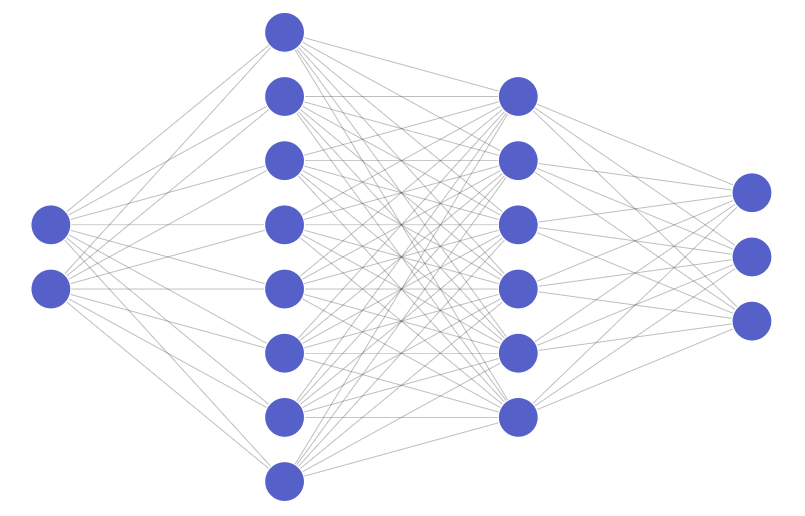

### Create the Q-Network: $\hat q(s,a| \theta)$

In [65]:
q_network = nn.Sequential(
    # nn..Linear; state * w + b; 2 (state dimensions) inputs and 128 outputs for the 1st hidden layer
    nn.Linear(state_dims, 128),
    
    # nn. ReLU max(0, state * w + b)
    nn.ReLU(),
    
    # 64 outputs for the 2nd hidden layer
    nn.Linear(128, 64),
    
    nn.ReLU(),
    
    # 3 outputs for the final layer, which are the Q-estimates
    nn.Linear(64, num_actions)

)

### Create the target Q-Network: $\hat q(s, a|\theta_{targ})$

In [66]:
target_q_network = copy.deepcopy(q_network)

# we don't want this target network to change its parameters
target_q_network = target_q_network.eval()

In [67]:
# an identical copy with its values frozen
target_q_network

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [68]:
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1,1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

<IPython.core.display.Javascript object>


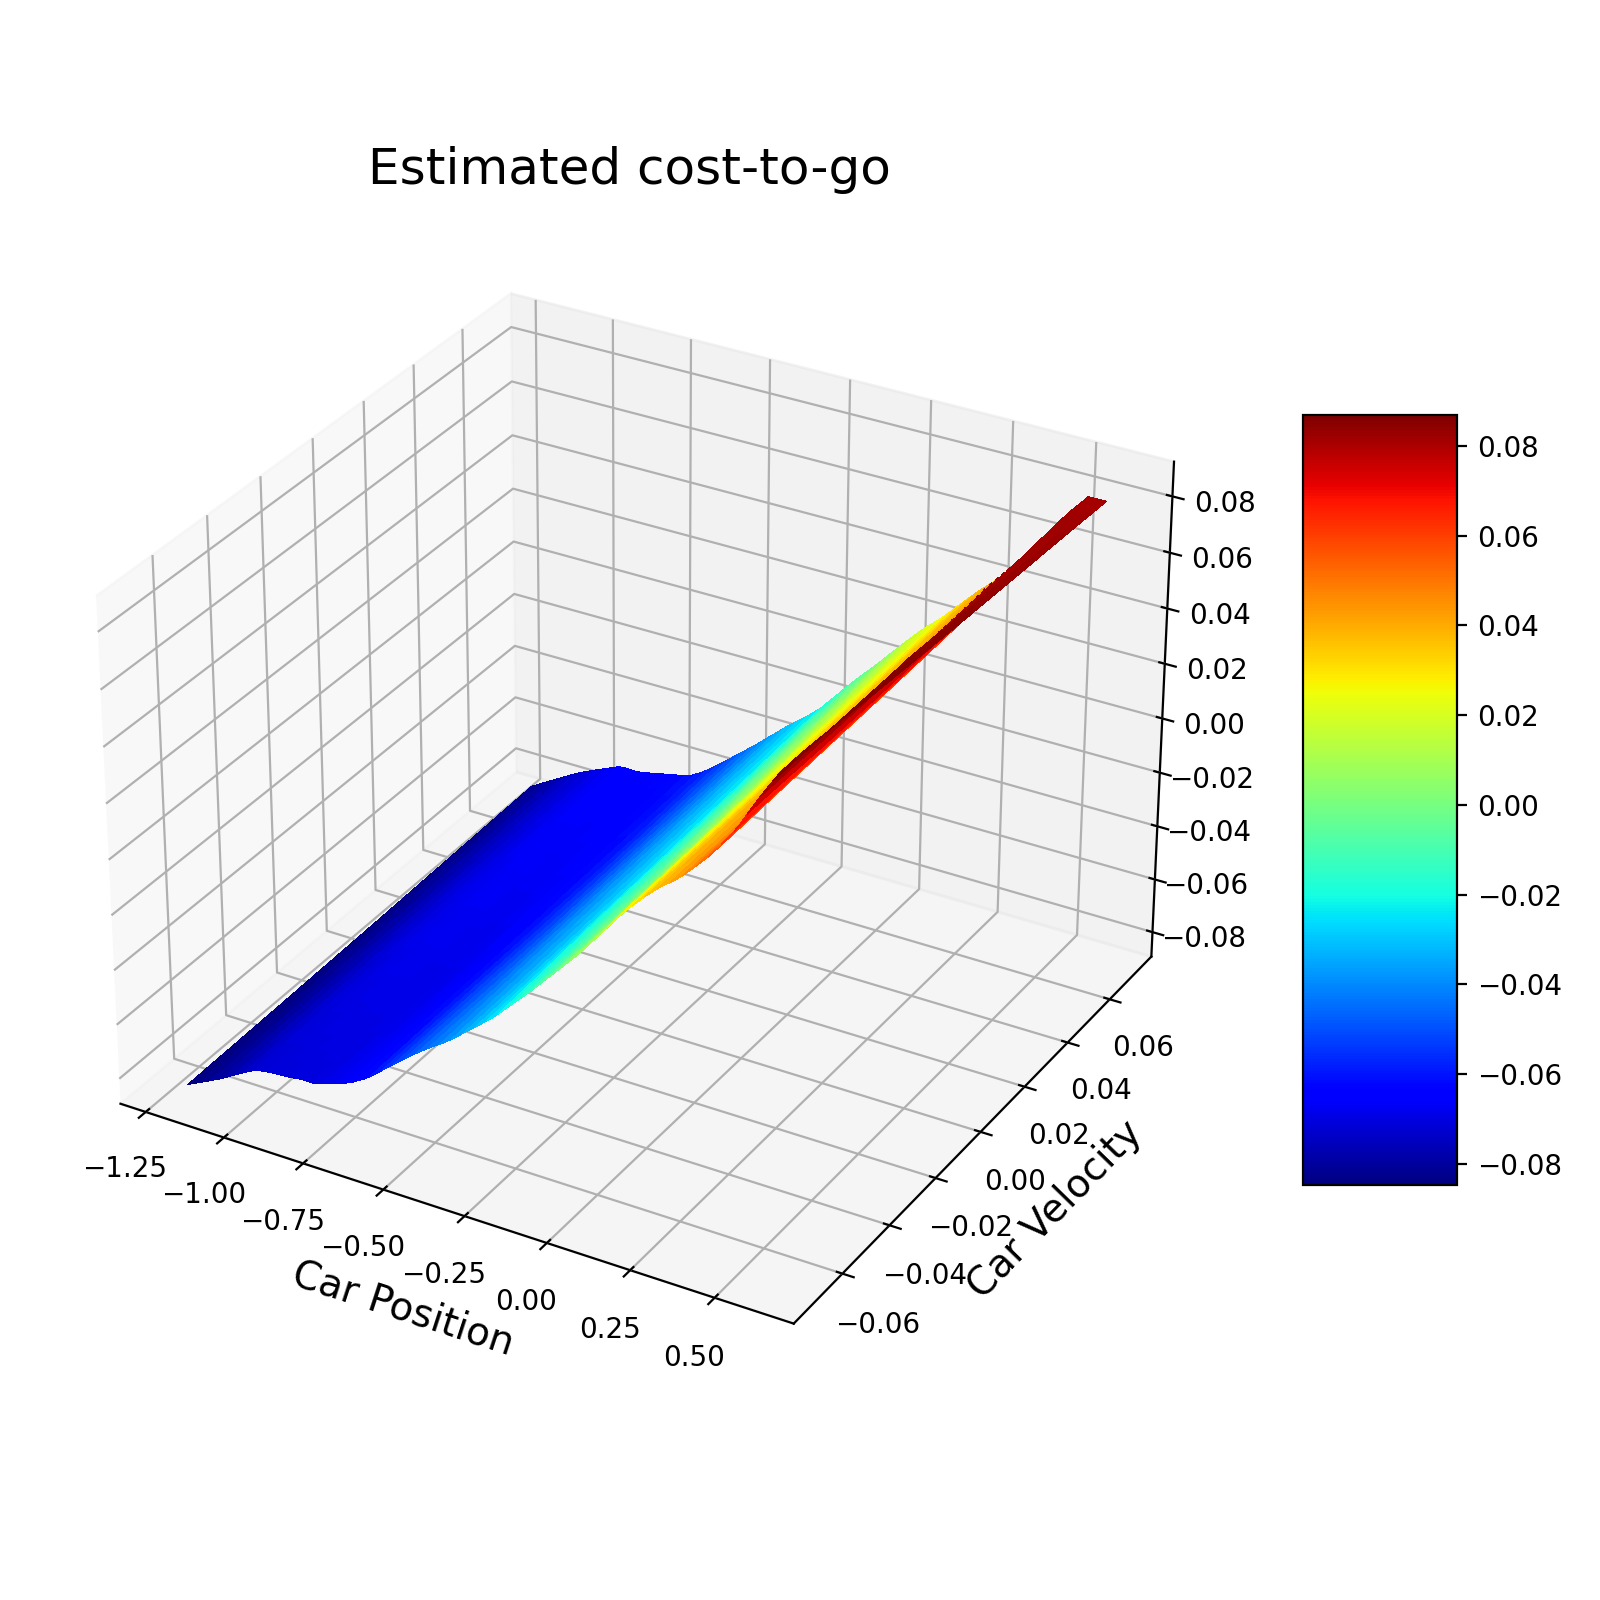

In [69]:
plot_cost_to_go(env, q_network, xlabel='Car Position', ylabel='Car Velocity')

## Create the Experience Replay buffer

<br>
<div style="text-align:center">
    <p>A simple buffer that stores transitions of arbitrary values, adapted from
    <a href="https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training">this source.</a></p>
</div>

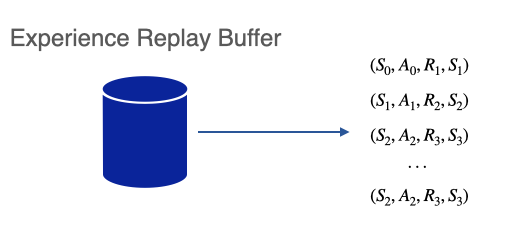


In [70]:
class ReplayMemory:
    
    # capacity is the maximum no. of transitions that this memory can store
    def __init__(self, capacity=1000000):
        self.capacity = capacity
        self.memory = []   # variable to store the transitions
        self.position = 0 # location to insert the next transition
        
    
    # insert a state transition in the memory eg. [s, a , r, s']
    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1)    % self.capacity
        
    
    # sample batches of experience from the memory eg. [[s, a, r, s'], [s, a, r, s']]
    def sample(self, batch_size):
        assert self.can_sample(batch_size)
        
        # it'll randomly pick from memory a specific no. of elements
        batch = random.sample(self.memory, batch_size)
        
        # [[s, a, r, s'], [s, a ,r , s']] -> [[s, s], [a, a], [r, r], [s', s']] we want this
        batch = zip(*batch)
        
        # convert each item into torch tensor
        return [torch.cat(items) for items in batch] # size will be N x D
    
    
    # check if memory has enough state transitions to begin drawing batches from it eg. True/False
    def can_sample(self, batch_size):
        # when amount of transitions in memory is at least 10 times the sie of the batch, we will sample batches from memory
        # we wait till the memory has 10 times as many transitions to avoid taking similar batches many times
        return len(self.memory) >= batch_size * 10
    
    
    # how many elements this object contains 
    def __len__(self):
        return len(self.memory)
    

## Implement the algorithm

</br></br>

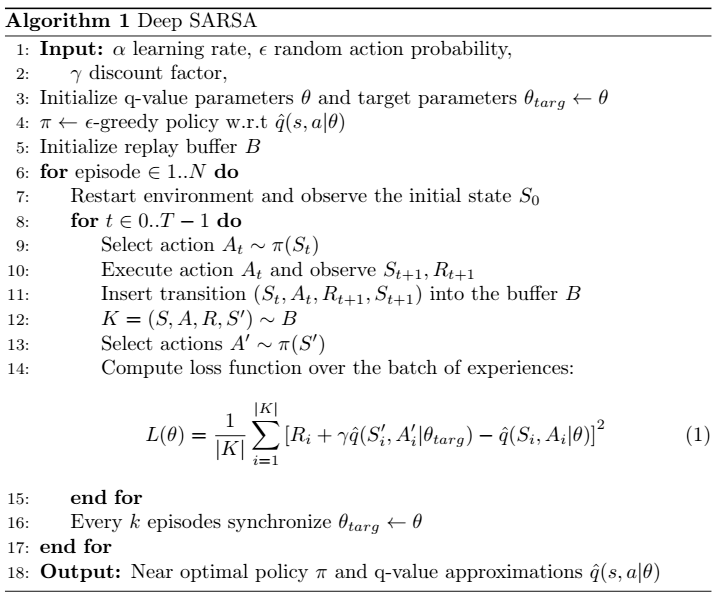

In [71]:
def deep_sarsa(q_network, policy, episodes, alpha=0.001, batch_size=32, gamma=0.99, epsilon=0.05):
    optim = AdamW(q_network.parameters(), lr=alpha)  
    # it is just a stochastic gradient descent with some modifications; lr - learning rate
    
    memory = ReplayMemory(capacity=1000000)
    stats = {'MSE Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        done = False
        ep_return = 0.
        
        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            memory.insert([state, action, reward, done, next_state])
            
            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                
                # batch of q_values to be generated from the batch of states above
                qsa_b = q_network(state_b).gather(1, action_b)
                
                next_action_b = policy(next_state_b, epsilon)
                
                next_qsa_b = target_q_network(next_state_b).gather(1, next_action_b)
                
                target_b = reward_b + ~done_b * gamma * next_qsa_b
                
                loss = F.mse_loss(qsa_b, target_b)
                
                # eliminate the previously computed gradients
                q_network.zero_grad()
                
                # start the backpropogation method to calc gradients of each parameter wrt cost func
                loss.backward()
                
                optim.step()
                
                stats['MSE Loss'].append(loss.item())
                
            state = next_state
            ep_return += reward.item()
            
        stats['Returns'].append(ep_return)
        
        # update the values of our target network after every 10 episodes and sync it
        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())
            
    return stats
    

In [80]:
stats = deep_sarsa(q_network, policy, episodes=3000, epsilon=0.01)

100%|███████████████████████████████████████| 3000/3000 [05:04<00:00,  9.86it/s]


## Show results

### Plot execution stats

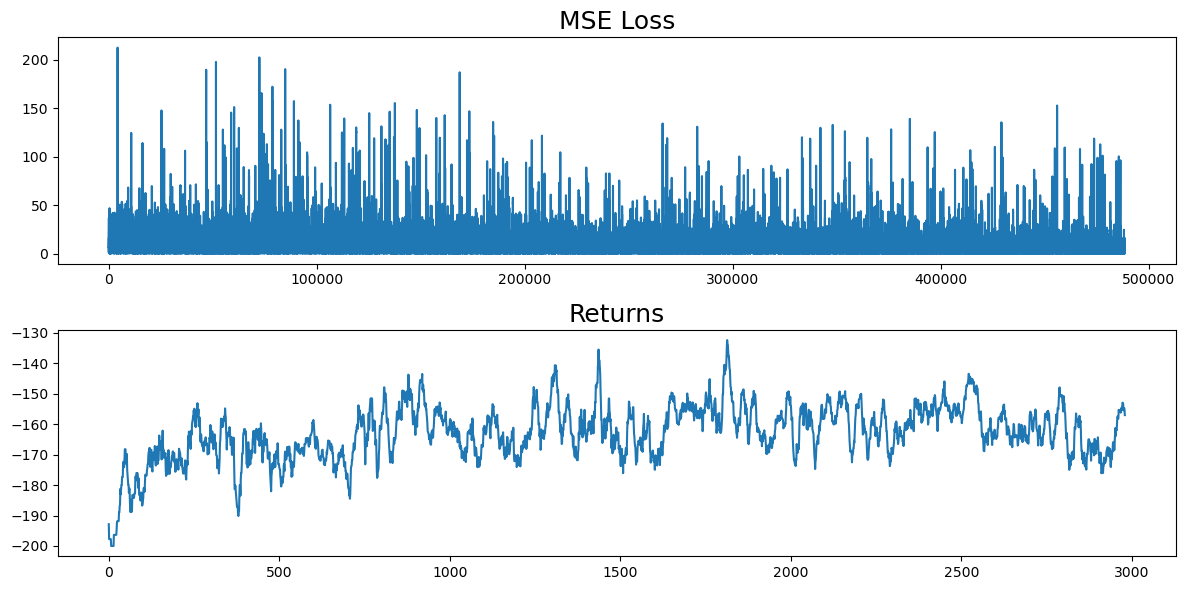

In [81]:
plot_stats(stats)

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

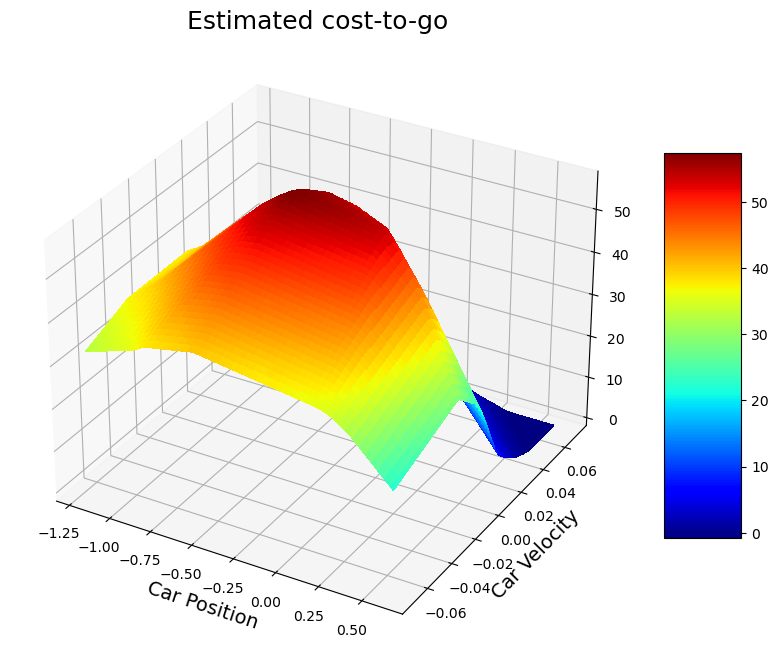

In [82]:
plot_cost_to_go(env, q_network, xlabel='Car Position', ylabel='Car Velocity')

### Show resulting policy: $\pi(s)$

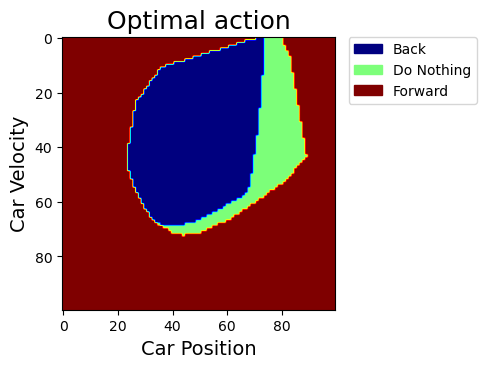

In [83]:
plot_max_q(env, q_network, xlabel='Car Position', ylabel='Car Velocity', action_labels=['Back', 'Do Nothing', 'Forward'])

### Test the resulting agent

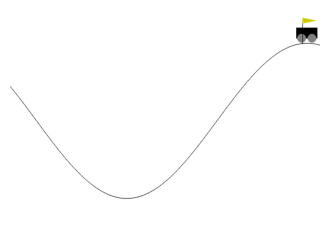

In [84]:
%matplotlib inline
test_agent(env, policy, episodes=2)

## Resources

[[1] Deep Reinforcement Learning with Experience Replay Based on SARSA](https://www.researchgate.net/publication/313803199_Deep_reinforcement_learning_with_experience_replay_based_on_SARSA)